# **OCT image segmentation**


1.   U-Net
  *   Optimizer - Adam with Learning Rate = 0.0001 (i.e) 1 * $e^{-4}$
  *   Loss - Categorical Focal Loss with Gamma ($\gamma$) = 2.8

2.   Attention Residual U-Net
  *   Optimizer - Adam with Leraning Rate = 0.001 (i.e) 1 * $e^{-3}$
  *   Loss - Categorical Focal Loss with Gamma ($\gamma$) = 3.0

3.   Attention Residual U-Net++
  *   Optimizer - SGD with Leraning Rate = 0.1 (i.e) 1 * $e^{-1}$
  *   Loss - Categorical Focal Loss with Gamma ($\gamma$) = 3.0

Image Resolution = 512 x 256

Batch size = 2

---

**Connect Google Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

---

**Install Requirements**


In [ ]:
!pip install tensorflow==2.8 matplotlib opencv-python scikit-learn segmentation_models protobuf==3.20.* gradio

---

**Imports & Constants**

In [1]:
import os
import gc
import sys
import glob
import random
from typing import Final 
from itertools import groupby

import cv2
import skimage
import numpy as np
import tensorflow as tf
import matplotlib as mpl
import segmentation_models as sm
from matplotlib import pyplot as plt
from tensorflow.keras import backend as K
from tensorflow.keras import layers, models
from sklearn.utils import compute_class_weight
from keras.utils.layer_utils import count_params
from tensorflow.keras.metrics import MeanIoU, IoU
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import KFold, train_test_split
from tensorflow.keras.metrics import TruePositives, TrueNegatives, FalsePositives, FalseNegatives


Segmentation Models: using `keras` framework.


In [2]:
SIZE: tuple = 256, 512

# Total number of segments in mask i.e total colors
NUMBER_CLASSES: int = 8 # Total Classes to segment

# Conversion based on size of OCT Scan Image resolution of 1.96 μm x 11.74 μm
PIXEL_TO_MICROMETER: float = 2 * 0.0019140625

# Check if execution environment is Google Colab
COLAB: bool = 'google.colab' in sys.modules
if COLAB:
    root = '/content/drive/MyDrive/Colab Notebooks'
else:
    root = '.'


RAW_IMAGE_DIR: str = f"{root}/dataset/train/raw/"
MASK_IMAGE_DIR: str = f"{root}/dataset/train/mask/"

# Padding Space for Image Showcase
PADDING: int = 10

BATCH_SIZE: int = 2

# Segmentations
CLASSES: dict = {
    0: "Black (Above ILM) ",
    1: "Red (ILM - IPL / INL) ",
    2: "Yellow (IPL / INL - RPE) ",
    3: "White (RPE - BM) ",
    4: "Blue (Under BM) ",
    5: "Cyan (PED) ",
    6: "Pink (SRF) ",
    7: "Green (IRF) ",
}

# Colors
BLACK = np.array([0, 0, 0])
WHITE = np.array([255, 255, 255])
RED = np.array([255, 0, 0])
GREEN = np.array([0, 255, 0])
BLUE = np.array([0, 0, 255])
YELLOW = np.array([255, 255, 0])
PINK = np.array([255, 0, 255])
CYAN = np.array([0, 255, 255])

---

**Helper Functions**

In [3]:
def rgb_to_label(label):
	label_seg = np.zeros(label.shape, dtype=np.uint8)
	label_seg [np.all(label == BLACK, axis=-1)] = 0
	label_seg [np.all(label == WHITE, axis=-1)] = 1
	label_seg [np.all(label == RED, axis=-1)] = 2
	label_seg [np.all(label == GREEN, axis=-1)] = 3
	label_seg [np.all(label == BLUE, axis=-1)] = 4
	label_seg [np.all(label == YELLOW, axis=-1)] = 5
	label_seg [np.all(label == PINK, axis=-1)] = 6
	label_seg [np.all(label == CYAN, axis=-1)] = 7

	label_seg = label_seg[:,:,0]

	return label_seg

# Converts Numbers to RGB i.e [R,G,B]
def label_to_rgb(predicted_image): 
	segmented_img = np.empty((predicted_image.shape[0], predicted_image.shape[1], 3))
	
	segmented_img[(predicted_image == 0)] = BLACK
	segmented_img[(predicted_image == 1)] = WHITE
	segmented_img[(predicted_image == 2)] = RED
	segmented_img[(predicted_image == 3)] = GREEN
	segmented_img[(predicted_image == 4)] = BLUE
	segmented_img[(predicted_image == 5)] = YELLOW
	segmented_img[(predicted_image == 6)] = PINK
	segmented_img[(predicted_image == 7)] = CYAN
	
	segmented_img = segmented_img.astype(np.uint8)
	return(segmented_img)

def image_array(path):
    images = []

    for directory_path in glob.glob(path):
        for img_path in sorted(glob.glob(os.path.join(directory_path, "*.png"))):
            img = cv2.imread(img_path, 1)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, SIZE)
            images.append(img)

    return np.array(images)

def raw_image_array(path):
    return image_array(path)

def categorical_array(arr):
    labels = []
    for i in range(arr.shape[0]):
        label = rgb_to_label(arr[i])
        labels.append(label)

    del arr
    labels = np.array(labels)
    return np.expand_dims(labels, axis=3)

def label_image_array(path):
    masks = image_array(path)
    return categorical_array(masks)

def detect_color(mask):
    return True if cv2.countNonZero(mask) else False

def get_mask_color(img, color):
    return cv2.inRange(img, color, color)

def mask_colors(img):
	pink_mask = get_mask_color(img, PINK)
	cyan_mask = get_mask_color(img, CYAN)
	white_mask = get_mask_color(img, WHITE)

	is_pink = detect_color(pink_mask)
	is_cyan = detect_color(cyan_mask)
	is_white = detect_color(white_mask)

	del pink_mask, white_mask, cyan_mask
	return CLASSES[6] * is_pink + CLASSES[5] * is_cyan + CLASSES[3] * is_white


def color(arr):
	if np.array_equal(arr, BLACK):
		return CLASSES[0]
	elif np.array_equal(arr, RED):
		return CLASSES[4]
	elif np.array_equal(arr, YELLOW):
		return CLASSES[5]
	elif np.array_equal(arr, WHITE):
		return CLASSES[3]
	elif np.array_equal(arr, BLUE):
		return CLASSES[1]
	elif np.array_equal(arr, CYAN):
		return CLASSES[2]
	elif np.array_equal(arr, PINK):
		return CLASSES[6]
	elif np.array_equal(arr, GREEN):
		return CLASSES[7]
	
# Sorts Contours from left most to right
def sort_contours(cnts, method="left-to-right"):
	i = 0
	boundingBoxes = [cv2.boundingRect(c) for c in cnts]
	try:
		(cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),
									 key=lambda b: b[1][i], reverse=False))
	except:
		pass
	# return the list of sorted contours and bounding boxes
	return cnts


def ordinal(n):
	return f"{n}{dict({1: 'st', 2: 'nd', 3: 'rd'}).get(4 if 10 <= n % 100 < 20 else n % 10, 'th')}"
#returns max thickness for each colored contour

def max_display(data):
	output = {}
	for key, value in groupby(data, lambda x: x['color']):
		output[key] = max(value, key=lambda y: y['max'])
	return output

# Finds thickness of a contour
def thickness(img, n):
	# img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
	# masks the colors
	pink_mask = cv2.inRange(img, PINK, PINK)
	cyan_mask = cv2.inRange(img, CYAN, CYAN)
	white_mask = cv2.inRange(img, WHITE, WHITE)
	mask = pink_mask + cyan_mask + white_mask  # type: ignore

	img_copy = img.copy()
	new_contours = []
	img2 = np.zeros_like(mask, dtype=np.uint8)
	contour_img = mask.copy()
	contour_img = cv2.merge([contour_img, contour_img, contour_img])

	# finds contours present in the masked image
	contours = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)  # type: ignore
	contours = contours[0] if len(contours) == 2 else contours[1]

	for cntr in contours:  
		cv2.drawContours(contour_img, [cntr], 0, (0, 255, 0), 1)
		cv2.drawContours(img2, [cntr], 0, (255), -1)
		new_contours.append(cntr)

	cnts_sort = sort_contours(new_contours)
	black = np.zeros_like(mask, dtype=np.uint8)

	data = []
 
	for cnt in cnts_sort:
	 
		# Fit ellipse to countour shape
		try:
			ellipse = cv2.fitEllipse(cnt) #[(x1,y1), (x2,y2), theta]
			angle = ellipse[-1]
			cv2.ellipse(contour_img, ellipse, (0, 0, 255), 2)  # type: ignore
			
			img3 = np.zeros(img.shape).astype(img.dtype)
			cv2.drawContours(img3, [cnt], 0, (255,255,255), -1)
			sep = cv2.bitwise_and(img, img3)
   
			mask_color = mask_colors(sep)
			cnt_img = black.copy()
			arrow_img = np.zeros(img.shape, np.uint8)

			cv2.drawContours(cnt_img, [cnt], 0, (255), -1)
			
			# Rotates image and finds thickness
			cnt_img_rot = skimage.transform.rotate(cnt_img, 270 + angle, resize=False)
			arrow_img = skimage.transform.rotate(arrow_img, 270 + angle, resize=False)

			cnt_non_zero = np.count_nonzero(cnt_img_rot, axis=0)
			thickness = np.mean(cnt_non_zero) 
			max_thickness = np.max(cnt_non_zero)
			img_copy_rot = skimage.transform.rotate(img_copy, 270 + angle, resize=False)

			def check(x): return 0 if x < 255 // 2 else 255
			vcheck = np.vectorize(check)
			
			max_x, max_y = np.argmax(cnt_non_zero), (cnt_img_rot != 0).argmax(axis=0)[np.argmax(cnt_non_zero)]
			
			datum = {
       				"contour": f"Contour: {mask_color.split(')')[0]})",
					"color": f"{mask_color.split(')')[0]})",
					"top": color(vcheck(img_copy_rot[max_y - 1, max_x][::-1] * 255)),
					"bottom": color(vcheck(img_copy_rot[max_y + max_thickness + 1, max_x][::-1] * 255)),
					"max": max_thickness * PIXEL_TO_MICROMETER,
					"max_print": f"{round(max_thickness * PIXEL_TO_MICROMETER, 3)} µm"
            		}

			data.append(datum)

			cv2.arrowedLine(arrow_img, (max_x, max_y), (max_x, max_y + max_thickness), (255, 255, 255), 1)
			cv2.arrowedLine(arrow_img, (max_x, max_y + max_thickness), (max_x, max_y), (255, 255, 255), 1)
			
			arrow_img = skimage.transform.rotate(arrow_img, -270 - angle, resize=False)

			arrow_img = arrow_img.astype(np.uint8)

			idx = (arrow_img!=0)
			img[idx] = arrow_img[idx]
		except cv2.error as e:
			continue
	return img, data


---

Loading Images

In [4]:
raw_images = raw_image_array(f"{root}/dataset/train/raw/")
masks = image_array(f"{root}/dataset/train/mask/")
labels = label_image_array(f"{root}/dataset/train/mask/")

labels_cat = to_categorical(labels, num_classes=NUMBER_CLASSES)
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(np.ravel(labels, order="C")), y=np.ravel(labels, order="C"))


---

Checking Images Shape

In [ ]:
np.shape(raw_images)
np.shape(masks)
print("Unique labels in label dataset are: ", np.unique(labels), np.shape(labels))

image_number = random.randint(0, len(raw_images) - 1)
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.title("Raw Image", pad = PADDING)
plt.imshow(raw_images[image_number])
plt.subplot(122)
plt.title("Mask Label", pad = PADDING)
plt.imshow(masks[image_number])
plt.show()

# Freeing up space
del masks, labels
gc.collect()

---

# Models

1. UNET

In [5]:
class Unet:
    def __init__(self, input_shape, filters, num_label):
        self.inputs = layers.Input(input_shape, dtype = tf.float32)
        self.filters = filters
        self.num_label = num_label
        self.model_name =  self.__class__.__name__
        
        self.pool_size = (2, 2)
        self.conv_size = (3, 3)
        self.conx_size = (2, 2)
        self.stride_size = (2, 2)
        
        contraction_1 = self.encoder(self.inputs, self.filters)
        pool_1 = layers.MaxPooling2D(self.pool_size)(contraction_1)
        
        contraction_2 = self.encoder(pool_1, 2 * self.filters)
        pool_2 = layers.MaxPooling2D(self.pool_size)(contraction_2)
        
        contraction_3 = self.encoder(pool_2, 4 * self.filters)
        pool_3 = layers.MaxPooling2D(self.pool_size)(contraction_3)
        
        contraction_4 = self.encoder(pool_3, 8 * self.filters)
        pool_4 = layers.MaxPooling2D(self.pool_size)(contraction_4)
        
        link_5 = self.encoder(pool_4, 16 * self.filters)
        
        expansion_4 = self.decoder(link_5, 8 * self.filters, contraction_4)
        expansion_3 = self.decoder(expansion_4, 4 * self.filters, contraction_3)
        expansion_2 = self.decoder(expansion_3, 2 * self.filters, contraction_2)
        expansion_1 = self.decoder(expansion_2, self.filters, contraction_1)
        
        outputs = layers.Conv2D(self.num_label, 3, activation="softmax", padding="same")(expansion_1)

        self.model = tf.keras.models.Model(self.inputs, outputs, name = self.model_name)
    
    def encoder(self, inputs, size):
        conv = layers.Conv2D(size, self.conv_size, padding='same')(inputs)
        conv = layers.Conv2D(size, self.conv_size, padding='same')(conv)
        bn = layers.BatchNormalization()(conv)
        act = layers.Activation("relu")(bn)
        
        return act
    
    def decoder(self, inputs, size, add):
        conx = layers.Conv2DTranspose(size, self.conx_size, strides=self.stride_size, padding='same')(inputs)
        up = layers.add([conx, add])
        conv = layers.Conv2D(size, self.conv_size, padding='same')(up)
        conv = layers.Conv2D(size, self.conv_size, padding='same')(conv)
        bn = layers.BatchNormalization()(conv)
        act = layers.Activation("relu")(bn)
        
        return act
    

2. ARUNET

In [6]:
class ARUnet:
    def __init__(self, input_shape, filters, num_label):
        self.inputs = layers.Input(input_shape, dtype = tf.float32)
        self.axis = 3
        self.filters = filters
        self.num_label = num_label
        self.model_name =  self.__class__.__name__
        
        self.pool_size = (2, 2)
        self.conv_size = (3, 3)
        self.conx_size = (2, 2)
        self.stride_size = (2, 2)
        
        conv_1 = self.res_conv_block(self.inputs, self.conv_size, self.filters)
        pool_1 = layers.MaxPooling2D(pool_size=self.pool_size)(conv_1)
        
        # Contraction 64
        conv_2 = self.res_conv_block(pool_1, self.conv_size, 2 * self.filters)
        pool_2 = layers.MaxPooling2D(pool_size=self.pool_size)(conv_2)
        
        # Contraction 128
        conv_3 = self.res_conv_block(pool_2, self.conv_size, 4 * self.filters)
        pool_3 = layers.MaxPooling2D(pool_size=self.pool_size)(conv_3)
        
        # Contraction 256
        conv_4 = self.res_conv_block(pool_3, self.conv_size, 8 * self.filters)
        pool_4 = layers.MaxPooling2D(pool_size=self.pool_size)(conv_4)
        
        # Contraction 512, convolution only
        link_5 = self.res_conv_block(pool_4, self.conv_size, 16 * self.filters)
    
        gating_4 = self.gating_signal(link_5, 8*self.filters)
        att_4 = self.attention_block(conv_4, gating_4, 8*self.filters)
        up_4 = layers.UpSampling2D(size=self.conx_size, data_format="channels_last")(link_5)
        up_4 = layers.concatenate([up_4, att_4], axis=self.axis)
        up_conv_4 = self.res_conv_block(up_4, self.conv_size, 8*self.filters)
        
        # Expansion 128
        gating_3 = self.gating_signal(up_conv_4, 4*self.filters)
        att_3 = self.attention_block(conv_3, gating_3, 4*self.filters)
        up_3 = layers.UpSampling2D(size=self.conx_size, data_format="channels_last")(up_conv_4)
        up_3 = layers.concatenate([up_3, att_3], axis=self.axis)
        up_conv_3 = self.res_conv_block(up_3, self.conv_size, 4*self.filters)
        
        # Expansion 64
        gating_2 = self.gating_signal(up_conv_3, 2*self.filters)
        att_2 = self.attention_block(conv_2, gating_2, 2*self.filters)
        up_2 = layers.UpSampling2D(size=self.conx_size, data_format="channels_last")(up_conv_3)
        up_2 = layers.concatenate([up_2, att_2], axis=self.axis)
        up_conv_2 = self.res_conv_block(up_2, self.conv_size, 2*self.filters)
        
        # Expansion 32
        gating_1 = self.gating_signal(up_conv_2, self.filters)
        att_1 = self.attention_block(conv_1, gating_1, self.filters)
        up_1 = layers.UpSampling2D(size=self.conx_size, data_format="channels_last")(up_conv_2)
        up_1 = layers.concatenate([up_1, att_1], axis=self.axis)
        up_conv_1 = self.res_conv_block(up_1, self.conv_size, self.filters)

        # 1*1 convolutional layers
        
        conv_final = layers.Conv2D(self.num_label, kernel_size=(1,1))(up_conv_1)
        conv_final = layers.BatchNormalization(axis=self.axis)(conv_final)
        conv_final = layers.Activation('softmax')(conv_final)

        # Model integration
        self.model = tf.keras.models.Model(self.inputs, conv_final, name="Attention_Residual_UNet")
    
    def repeat_elem(self, tensor, rep):
        return layers.Lambda(lambda x, repnum: K.repeat_elements(x, repnum, axis=3),
                                arguments={'repnum': rep})(tensor)

    def res_conv_block(self, x, conv_size, size):
        
        conv = layers.Conv2D(size, conv_size, padding='same')(x)
        conv = layers.BatchNormalization(axis=3)(conv)
        # conv = layers.Activation('relu')(conv)
        
        # conv = layers.Conv2D(size, conv_size, padding='same')(conv)
        # conv = layers.BatchNormalization(axis=3)(conv)
        

        shortcut = layers.Conv2D(size, kernel_size=(1, 1), padding='same')(x)
        shortcut = layers.BatchNormalization(axis=3)(shortcut)

        res_path = layers.add([shortcut, conv])
        res_path = layers.Activation('relu')(res_path)    #Activation after addition with shortcut (Original residual block)
        return res_path

    def gating_signal(self, input, out_size):
        x = layers.Conv2D(out_size, (1, 1), padding='same')(input)
        x = layers.BatchNormalization()(x)
        x = layers.Activation('relu')(x)
        return x

    def attention_block(self, x, gating, inter_shape):
        shape_x = K.int_shape(x)
        shape_g = K.int_shape(gating)

        theta_x = layers.Conv2D(inter_shape, (2, 2), strides=(2, 2), padding='same')(x)
        shape_theta_x = K.int_shape(theta_x)

        phi_g = layers.Conv2D(inter_shape, (1, 1), padding='same')(gating)
        upsample_g = layers.Conv2DTranspose(inter_shape, (3, 3), strides=(shape_theta_x[1] // shape_g[1], shape_theta_x[2] // shape_g[2]), padding='same')(phi_g)

        concat_xg = layers.add([upsample_g, theta_x])
        act_xg = layers.Activation('relu')(concat_xg)
        psi = layers.Conv2D(1, (1, 1), padding='same')(act_xg)
        sigmoid_xg = layers.Activation('sigmoid')(psi)
        shape_sigmoid = K.int_shape(sigmoid_xg)
        upsample_psi = layers.UpSampling2D(size=(shape_x[1] // shape_sigmoid[1], shape_x[2] // shape_sigmoid[2]))(sigmoid_xg)  # 32

        upsample_psi = self.repeat_elem(upsample_psi, shape_x[3])

        y = layers.multiply([upsample_psi, x])

        result = layers.Conv2D(shape_x[3], (1, 1), padding='same')(y)
        result_bn = layers.BatchNormalization()(result)
        return result_bn

3. ARUNET++

In [7]:
class ARUnetPP:
    def __init__(self, input_shape, filters, num_label):
        self.inputs = layers.Input(input_shape, dtype = tf.float32)
        self.axis = 3
        self.filters = filters
        self.num_label = num_label
        self.model_name =  self.__class__.__name__
        
        # cant modify these
        self.pool_size = (2, 2)
        self.conx_size = (2, 2)
        
        # can increase these
        self.conv_size = (4, 4)
        
        # can decrease to 1,1
        self.stride_size = (1, 1)
        
        conv_1 = self.res_conv_block(self.inputs, self.conv_size, self.filters)
        pool_1 = layers.MaxPooling2D(pool_size=self.pool_size)(conv_1)
        
        # Contraction 64
        conv_2 = self.res_conv_block(pool_1, self.conv_size, 2 * self.filters)
        pool_2 = layers.MaxPooling2D(pool_size=self.pool_size)(conv_2)
        
        # Contraction 128
        conv_3 = self.res_conv_block(pool_2, self.conv_size, 4 * self.filters)
        pool_3 = layers.MaxPooling2D(pool_size=self.pool_size)(conv_3)
        
        # Contraction 256
        conv_4 = self.res_conv_block(pool_3, self.conv_size, 8 * self.filters)
        pool_4 = layers.MaxPooling2D(pool_size=self.pool_size)(conv_4)
        
        # Contraction 512, convolution only
        link_5 = self.res_conv_block(pool_4, self.conv_size, 16 * self.filters)
    
        gating_4 = self.gating_signal(link_5, 8*self.filters)
        att_4 = self.attention_block(conv_4, gating_4, 8*self.filters)
        up_4 = layers.UpSampling2D(size=self.conx_size, data_format="channels_last")(link_5)
        up_4 = layers.concatenate([up_4, att_4], axis=self.axis)
        up_conv_4 = self.res_conv_block(up_4, self.conv_size, 8*self.filters)
        
        # Expansion 128
        gating_3 = self.gating_signal(up_conv_4, 4*self.filters)
        att_3 = self.attention_block(conv_3, gating_3, 4*self.filters)
        up_3 = layers.UpSampling2D(size=self.conx_size, data_format="channels_last")(up_conv_4)
        up_3 = layers.concatenate([up_3, att_3], axis=self.axis)
        up_conv_3 = self.res_conv_block(up_3, self.conv_size, 4*self.filters)
        
        # Expansion 64
        gating_2 = self.gating_signal(up_conv_3, 2*self.filters)
        att_2 = self.attention_block(conv_2, gating_2, 2*self.filters)
        up_2 = layers.UpSampling2D(size=self.conx_size, data_format="channels_last")(up_conv_3)
        up_2 = layers.concatenate([up_2, att_2], axis=self.axis)
        up_conv_2 = self.res_conv_block(up_2, self.conv_size, 2*self.filters)
        
        # Expansion 32
        gating_1 = self.gating_signal(up_conv_2, self.filters)
        att_1 = self.attention_block(conv_1, gating_1, self.filters)
        up_1 = layers.UpSampling2D(size=self.conx_size, data_format="channels_last")(up_conv_2)
        up_1 = layers.concatenate([up_1, att_1], axis=self.axis)
        up_conv_1 = self.res_conv_block(up_1, self.conv_size, self.filters)

        # 1*1 convolutional layers
        
        conv_final = layers.Conv2D(self.num_label, kernel_size=(1,1))(up_conv_1)
        conv_final = layers.BatchNormalization(axis=self.axis)(conv_final)
        conv_final = layers.Activation('softmax')(conv_final)

        # Model integration
        self.model = tf.keras.models.Model(self.inputs, conv_final, name="Attention_Residual_UNetPP")
    
    def repeat_elem(self, tensor, rep):
        return layers.Lambda(lambda x, repnum: K.repeat_elements(x, repnum, axis=3),
                                arguments={'repnum': rep})(tensor)

    def res_conv_block(self, x, conv_size, size):
        
        conv = layers.Conv2D(size, conv_size, padding='same')(x)
        conv = layers.BatchNormalization(axis=3)(conv)
        # conv = layers.Activation('relu')(conv)
        
        # conv = layers.Conv2D(size, conv_size, padding='same')(conv)
        # conv = layers.BatchNormalization(axis=3)(conv)
        

        shortcut = layers.Conv2D(size, kernel_size=(1, 1), padding='same')(x)
        shortcut = layers.BatchNormalization(axis=3)(shortcut)

        res_path = layers.add([shortcut, conv])
        res_path = layers.Activation('relu')(res_path)    #Activation after addition with shortcut (Original residual block)
        return res_path

    def gating_signal(self, input, out_size):
        x = layers.Conv2D(out_size, (1, 1), padding='same')(input)
        x = layers.BatchNormalization()(x)
        x = layers.Activation('relu')(x)
        return x

    def attention_block(self, x, gating, inter_shape):
        shape_x = K.int_shape(x)
        shape_g = K.int_shape(gating)

        theta_x = layers.Conv2D(inter_shape, (2, 2), strides=(2, 2), padding='same')(x)
        shape_theta_x = K.int_shape(theta_x)

        phi_g = layers.Conv2D(inter_shape, (1, 1), padding='same')(gating)
        upsample_g = layers.Conv2DTranspose(inter_shape, (3, 3), strides=(shape_theta_x[1] // shape_g[1], shape_theta_x[2] // shape_g[2]), padding='same')(phi_g)

        concat_xg = layers.add([upsample_g, theta_x])
        act_xg = layers.Activation('relu')(concat_xg)
        psi = layers.Conv2D(1, (1, 1), padding='same')(act_xg)
        sigmoid_xg = layers.Activation('sigmoid')(psi)
        shape_sigmoid = K.int_shape(sigmoid_xg)
        upsample_psi = layers.UpSampling2D(size=(shape_x[1] // shape_sigmoid[1], shape_x[2] // shape_sigmoid[2]))(sigmoid_xg)  # 32

        upsample_psi = self.repeat_elem(upsample_psi, shape_x[3])

        y = layers.multiply([upsample_psi, x])

        result = layers.Conv2D(shape_x[3], (1, 1), padding='same')(y)
        result_bn = layers.BatchNormalization()(result)
        return result_bn

---

# Training

---

* Metrics, Losses & Optimizers

In [8]:
input_shape = raw_images.shape[1:]

dice_loss = sm.losses.DiceLoss(class_weights=class_weights, per_image=True)

unet_focal_loss = sm.losses.CategoricalFocalLoss(2.8)
unet_total_loss = dice_loss + (2 * unet_focal_loss)

arnet_focal_loss = sm.losses.CategoricalFocalLoss(3.0)
arnet_total_loss = 1.5 * arnet_focal_loss

def jacard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)

metrics = ['accuracy', jacard_coef]

adam_optimizer = Adam(learning_rate=1e-3)
sgd_optimizer = SGD(learning_rate=0.1, momentum=0.9, decay=0.0005)

del class_weights
gc.collect()

0

---

**K-Fold Cross Validation**

In [9]:
kf = KFold(n_splits=5)
cross_val_score = {}
unet_model = Unet(input_shape, 32,  NUMBER_CLASSES)
unet_model.model.compile(optimizer = adam_optimizer, loss = unet_total_loss, metrics = metrics, run_eagerly = True)

arunet_model = ARUnet(input_shape, 32,  NUMBER_CLASSES)
arunet_model.model.compile(optimizer = adam_optimizer, loss = arnet_total_loss, metrics = metrics, run_eagerly = True)

arunetpp_model = ARUnetPP(input_shape, 32,  NUMBER_CLASSES)
arunetpp_model.model.compile(optimizer = sgd_optimizer, loss = arnet_total_loss, metrics = metrics, run_eagerly = True)

MODELS = [unet_model, arunet_model, arunetpp_model]
for model in MODELS:
    local_cvs = []
    for train_index, test_index in kf.split(raw_images, labels_cat):

        X_train, X_test, y_train, y_test = raw_images[train_index], raw_images[test_index], labels_cat[train_index], labels_cat[test_index]
        model.model.fit(X_train, y_train, batch_size = BATCH_SIZE, verbose = 1, epochs = 15, shuffle = False)
        
        
        local_cvs.append( model.model.evaluate(X_test, y_test, batch_size = BATCH_SIZE)[-1])
        del X_train, X_test, y_train, y_test
        gc.collect()
    
    
    cross_val_score[model.model.name] = local_cvs
for model, cvs in cross_val_score.items():
    print(model)
    for n, jc in enumerate(cvs, 1):
        print(f"Jacard Coefficient for {n} Split: {round(jc * 100, 2)}")

    np_cross_val_score = np.array(cvs)
    print(f"Average Jacard Coefficient for 5-Fold Split: {round(np_cross_val_score.mean()* 100, 2)}")

del unet_model, arunet_model, arunetpp_model, MODELS
gc.collect()

Epoch 1/15
400/400 [==============================] - 46s 92ms/step - loss: -1.4603 - accuracy: 0.7708 - jacard_coef: 0.5236
Epoch 2/15
400/400 [==============================] - 36s 91ms/step - loss: -2.3429 - accuracy: 0.7296 - jacard_coef: 0.4897
Epoch 3/15
400/400 [==============================] - 37s 91ms/step - loss: -2.4450 - accuracy: 0.6815 - jacard_coef: 0.4484
Epoch 4/15
400/400 [==============================] - 36s 91ms/step - loss: -1.9244 - accuracy: 0.6672 - jacard_coef: 0.4406
Epoch 5/15
400/400 [==============================] - 37s 92ms/step - loss: -2.7122 - accuracy: 0.6940 - jacard_coef: 0.4619
Epoch 6/15
400/400 [==============================] - 37s 92ms/step - loss: -3.0679 - accuracy: 0.7611 - jacard_coef: 0.4861
Epoch 7/15
400/400 [==============================] - 37s 92ms/step - loss: -3.0632 - accuracy: 0.7634 - jacard_coef: 0.5049
Epoch 8/15
400/400 [==============================] - 37s 92ms/step - loss: -6.5712 - accuracy: 0.7804 - jacard_coef: 0.5329


29407

---

* Data Split

In [9]:
x_train, x_val, y_train, y_val = train_test_split(raw_images, labels_cat, test_size=0.20, random_state=42)

* Model Initiation & Compilation

In [11]:
unet_model = Unet(input_shape, 32,  NUMBER_CLASSES)
arunet_model = ARUnet(input_shape, 32,  NUMBER_CLASSES)
arunetpp_model = ARUnetPP(input_shape, 32,  NUMBER_CLASSES)

unet_model.model.compile(optimizer = adam_optimizer, loss = unet_total_loss, metrics = metrics, run_eagerly = True)
arunet_model.model.compile(optimizer = adam_optimizer, loss = arnet_total_loss, metrics = metrics, run_eagerly = True)
arunetpp_model.model.compile(optimizer = sgd_optimizer, loss = arnet_total_loss, metrics = metrics, run_eagerly = True)

print("Trainable Parameters")
print(f"UNET: {count_params(unet_model.model.trainable_weights)}")
print(f"ARUNET: {count_params(arunet_model.model.trainable_weights)}")
print(f"ARWNET: {count_params(arunetpp_model.model.trainable_weights)}")

del raw_images, labels_cat
gc.collect()

Trainable Parameters
UNET: 6981960
ARUNET: 5846556
ARWNET: 8893628


953

---

* Model Fitting

In [ ]:
# unet_history = unet_model.model.fit(x_train, y_train, batch_size=BATCH_SIZE, verbose=1, epochs=15, shuffle=False)
# del unet_model.model
# gc.collect()

arunet_history = arunet_model.model.fit(x_train, y_train, batch_size=BATCH_SIZE, verbose=1, epochs=15, shuffle=False)
arunet_model.model.save("arunet-less")
del arunet_model.model
gc.collect()

arunetpp_history = arunetpp_model.model.fit(x_train, y_train, batch_size=BATCH_SIZE, verbose=1, epochs=15, shuffle=False)
arunetpp_model.model.save("arunetpp-less")
del arunetpp_model.model
gc.collect()

---

* Graph


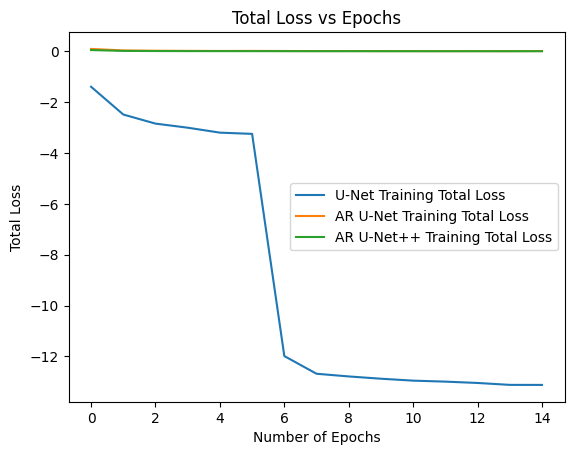

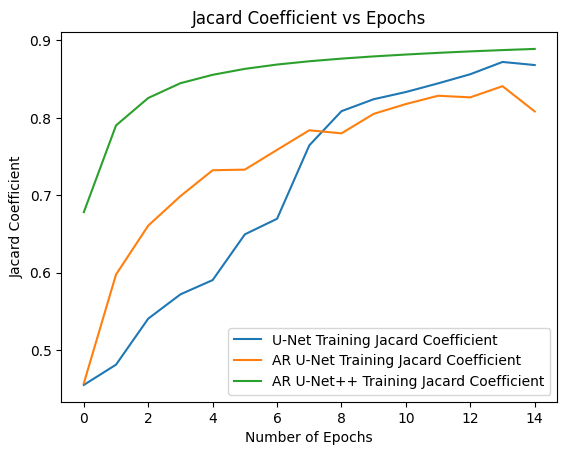

4027

In [13]:
mpl.rc('axes.spines', top = True, bottom = True, left = True, right = True)
mpl.rc('axes', facecolor = (1, 1, 1, 1), edgecolor = (0, 0, 0, 1))
mpl.rc(('xtick','ytick'), color = (0, 0, 0, 1))
plt.plot(unet_history.history["loss"], label ="U-Net Training Total Loss")
plt.plot(arunet_history.history["loss"], label ="AR U-Net Training Total Loss")
plt.plot(arunetpp_history.history["loss"], label ="AR U-Net++ Training Total Loss")

plt.ylabel("Total Loss")
plt.xlabel("Number of Epochs")
plt.title("Total Loss vs Epochs")
plt.legend()
plt.show()

plt.plot(unet_history.history["jacard_coef"], label ="U-Net Training Jacard Coefficient")
plt.plot(arunet_history.history["jacard_coef"], label ="AR U-Net Training Jacard Coefficient")
plt.plot(arunetpp_history.history["jacard_coef"], label ="AR U-Net++ Training Jacard Coefficient")

plt.ylabel("Jacard Coefficient")
plt.xlabel("Number of Epochs")
plt.title("Jacard Coefficient vs Epochs")
plt.legend()
plt.show()

del unet_history, arunet_history, arunetpp_history
gc.collect()

* Model Loading


In [13]:
unet_model = models.load_model(f'{root}/unet', compile = False)
arunet_model =  models.load_model(f'{root}/arunet-less', compile = False, custom_objects={"K": K,})
arunetpp_model =  models.load_model(f'{root}/arunetpp-less', compile = False, custom_objects={"K": K,})

MODELS = [unet_model, arunet_model, arunetpp_model]

del unet_model, arunet_model, arunetpp_model
gc.collect()

1334

---

# Validation

* Prediction on Test Data

Unet Prediction

1st Contour: Pink (SRF), inbetween Yellow (IPL / INL - RPE)  and Green (IRF) 
Maximum Thickness = 0.015 um


2nd Contour: Pink (SRF), inbetween Yellow (IPL / INL - RPE)  and Green (IRF) 
Maximum Thickness = 0.019 um


3rd Contour: Pink (SRF), inbetween Yellow (IPL / INL - RPE)  and Blue (Under BM) 
Maximum Thickness = 0.138 um


4th Contour: Pink (SRF), inbetween Yellow (IPL / INL - RPE)  and Green (IRF) 
Maximum Thickness = 0.019 um


5th Contour: Pink (SRF), inbetween Yellow (IPL / INL - RPE)  and Green (IRF) 
Maximum Thickness = 0.019 um

AR UNet Prediction

1st Contour: Cyan (PED), inbetween Green (IRF)  and Blue (Under BM) 
Maximum Thickness = 0.126 um


2nd Contour: Pink (SRF), inbetween Yellow (IPL / INL - RPE)  and Green (IRF) 
Maximum Thickness = 0.031 um


3rd Contour: White (RPE - BM), inbetween Yellow (IPL / INL - RPE)  and Yellow (IPL / INL - RPE) 
Maximum Thickness = 0.015 um


4th Contour: White (RPE - BM), inbetween Yellow (IPL / INL - RPE)  and Yellow 

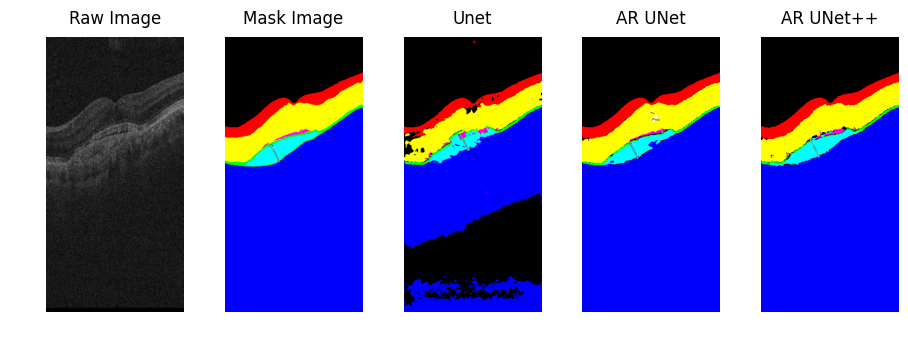

In [15]:
mpl.rc('axes.spines', top = False, bottom = False, left = False, right = False)
mpl.rc('axes', facecolor = (1, 1, 1, 0), edgecolor = (1, 1, 1, 0))
mpl.rc(('xtick','ytick'), color = (1, 1, 1, 0))

x_test = raw_image_array(f"{root}/dataset/test/raw/")
y_test = image_array(f"{root}/dataset/test/mask/")
test_labels = categorical_array(y_test)
test_labels = to_categorical(test_labels, num_classes=NUMBER_CLASSES)

# for test_img_number in range(len(x_test)):
test_img_number = random.randint(0, len(x_test) - 1)
test_img = x_test[test_img_number]

y_test_argmax=np.argmax(test_labels, axis=3)

ground_truth = y_test[test_img_number]
test_img_input = np.expand_dims(test_img, 0)


fig = plt.figure(figsize=(11, 5))

plt.subplot(1, 5, 1)
plt.subplots_adjust(wspace=0.3)
plt.title('Raw Image', pad=PADDING)
plt.imshow(test_img)

plt.subplot(1, 5, 2)
plt.subplots_adjust(wspace=0.3)
plt.title('Mask Image', pad=PADDING)
plt.imshow(thickness(ground_truth, 'Mask')[0])
for n, model in enumerate(MODELS, 3):
    y_pred = model.predict(x_test, batch_size=BATCH_SIZE)
    y_pred_argmax = np.argmax(y_pred, axis=3)

    prediction = model.predict(test_img_input)
    predicted_img = label_to_rgb(np.argmax(prediction, axis=3)[0,:,:])
    
    plt.subplot(1, 5, n)
    plt.subplots_adjust(wspace=0.3)
    plt.title(f"{model.name.replace('Attention_Residual_', 'AR ').replace('PP', '++')}", pad = PADDING)
    im, res = thickness(predicted_img, model.name.replace('Attention_Residual_', 'AR '))
    plt.imshow(im)
    print(f"{model.name.replace('Attention_Residual_', 'AR ').replace('PP', '++')} Prediction")
    for i, t in enumerate(res, 1):
        print(f"\n{ordinal(i)} {t['contour']}, inbetween {t['top']} and {t['bottom']}\nMaximum Thickness = {t['max_print']}\n")
    
    del model, y_pred, y_pred_argmax, prediction, predicted_img, #im, res
    gc.collect()

plt.savefig(f"results/tmp/{test_img_number}.png")
plt.show()

---

# Results

In [ ]:
mean_iou = MeanIoU(num_classes=NUMBER_CLASSES)


def metric(m, y_test, y_pred):
    m.reset_state()
    m.update_state(y_test, y_pred)
    return m.result().numpy()


def numeric_scores(y_test, y_pred):
    TFPN = TruePositives(), TrueNegatives(), FalsePositives(), FalseNegatives()
    scores = []
    for score in TFPN:
        score.reset_state()
        score.update_state(y_test, y_pred)
        scores.append(score.result().numpy())
    return scores


def precision_score(TP, TN, FP, FN):
    # PPV
    precision = np.divide(TP, TP + FP) * 100.0
    return round(precision, 2)


def recall_score(TP, TN, FP, FN):
    # TPR, sensitivity
    TPR = np.divide(TP, TP + FN) * 100.0
    return round(TPR, 2)


def specificity_score(TP, TN, FP, FN):
    TNR = np.divide(TN, TN + FP) * 100.0
    return round(TNR, 2)


def fallout(TP, TN, FP, FN):
    # FPR
    return round(100 - specificity_score(TP, TN, FP, FN), 2)


def miss_rate(TP, TN, FP, FN):
    # FNR
    return round(100 - recall_score(TP, TN, FP, FN), 2)


def accuracy_score(TP, TN, FP, FN):
    accuracy = np.divide(TP + TN, FP + FN + TP + TN) * 100.0
    return round(accuracy, 2)

for i, model in enumerate(MODELS):
    y_pred = model.predict(x_test)
    y_pred_argmax = np.argmax(y_pred, axis=3)
    TP, TN, FP, FN = numeric_scores(test_labels, y_pred)
    
    Precision = precision_score(TP, TN, FP, FN)
    Recall = recall_score(TP, TN, FP, FN)
    Specificity = specificity_score(TP, TN, FP, FN)
    Fallout = fallout(TP, TN, FP, FN)
    Miss_Rate = miss_rate(TP, TN, FP, FN)
    Accuracy = accuracy_score(TP, TN, FP, FN)
    Balanced_Accuracy = round(np.average((Recall, Specificity)), 2)

    Mean_IoU = round(metric(mean_iou, y_test_argmax, y_pred_argmax) * 100, 2)

    output = f"\n\n{model.name}:\n\tPrecision = {Precision}%\n\tRecall = {Recall}%\n\tSpecificity = {Specificity}%\n\tFallout = {Fallout}%\n\tMiss Rate = {Miss_Rate}%\n\tAccuracy = {Accuracy}%\n\tBalanced = {Balanced_Accuracy}%\n\tMean IoU = {Mean_IoU}%"

    for cls in CLASSES:
        class_iou = IoU(num_classes=NUMBER_CLASSES, target_class_ids=[cls])
        Class_IoU = round(metric(class_iou, y_test_argmax, y_pred_argmax) * 100, 2)
        output += f"\n\t\t{CLASSES[cls]} = {Class_IoU}%"

    print(output)
    
    del model, y_pred, y_pred_argmax, TP, TN, FP, FN, Precision, Accuracy, Recall, Specificity, Fallout, Miss_Rate, Balanced_Accuracy, Mean_IoU
    gc.collect()
    

  

---

# GUI

Running on local URL:  http://127.0.0.1:7861

Setting up a public link... we have recently upgraded the way public links are generated. If you encounter any problems, please report the issue and downgrade to gradio version 3.13.0
.
Running on public URL: https://1c445bce-2f60-4b28.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades (NEW!), check out Spaces: https://huggingface.co/spaces


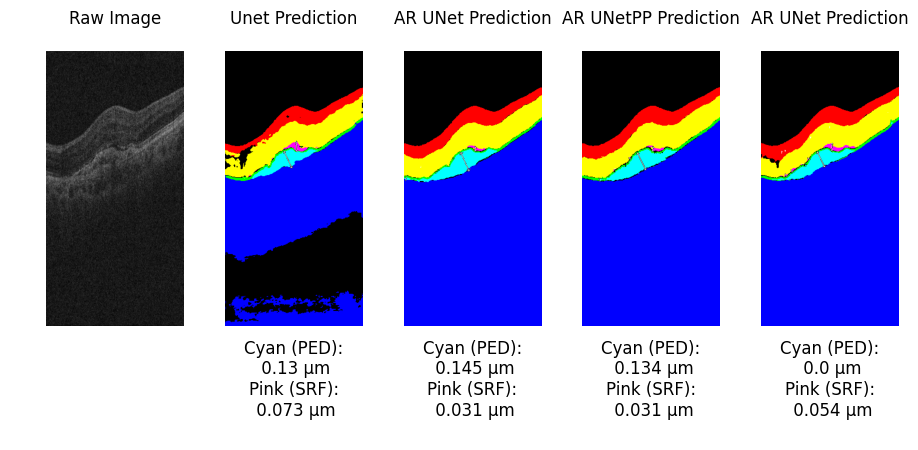

d:\Freelance\re OCT\venv\lib\site-packages\keras\layers\core\lambda_layer.py:303: UserWarning: Models.ARUnet is not loaded, but a Lambda layer uses it. It may cause errors.
  function = cls._parse_function_from_config(config, custom_objects,


d:\Freelance\re OCT\venv\lib\site-packages\keras\layers\core\lambda_layer.py:303: UserWarning: Models.ARUnetPP is not loaded, but a Lambda layer uses it. It may cause errors.
  function = cls._parse_function_from_config(config, custom_objects,


In [5]:
import gradio as gr
import cv2
from matplotlib import pyplot as plt
import numpy as np
import io
import gc

from tensorflow.keras import backend as K
from tensorflow.keras import models


def segment(image):
    img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (256, 512))
    
    unet_model = models.load_model(f'{root}/unet', compile = False)
    arunet_model =  models.load_model(f'{root}/arunet', compile = False, custom_objects={"K": K,})
    arunetpp_model =  models.load_model(f'{root}/arunetpp', compile = False, custom_objects={"K": K,})
    arwnet_model = models.load_model(f'{root}/arwnet', compile = False, custom_objects={"K": K,})

    MODELS = [unet_model, arunet_model, arunetpp_model, arwnet_model]
    del unet_model, arunet_model, arunetpp_model, arwnet_model
    gc.collect()
    
    plt.rc('axes.spines', top=False, bottom=False, left=False, right=False)
    plt.rc('axes', facecolor=(1, 1, 1, 0), edgecolor=(1, 1, 1, 0))
    plt.rc(('xtick', 'ytick'), color=(1, 1, 1, 0))

    fig = plt.figure(figsize=(11, 6))

    plt.subplot(1, 5, 1)
    plt.subplots_adjust(wspace=0.3)
    plt.title('Raw Image', pad=20)
    plt.imshow(img)

    html = "<b><h1 style='text-align: center'>Information</h1></b>"
    for n, model in enumerate(MODELS, 2):
    
        test_img_input = np.expand_dims(img, 0)
        prediction = model.predict(test_img_input)
        predicted_img = label_to_rgb(np.argmax(prediction, axis=3)[0, :, :])

        ax = plt.subplot(1, 5, n)
        plt.title(
            f"{model.name.replace('Attention_Residual_', 'AR ').replace('PP', '++')} Prediction", pad=20)
        
        im, dt = thickness(predicted_img, model.name.replace('Attention_Residual_', 'AR ').replace('PP', '++'))
        text = ""
        for k, v in max_display(dt).items():
            text += f"{k}:\n {v['max_print']}\n"
        
        ax.text(0.5, -0.4, text, size=12, ha="center", transform=ax.transAxes)
        plt.imshow(im)
        
        detailed_text = f"<h2><b>{model.name.replace('Attention_Residual_', 'AR ').replace('PP', '++')} Prediction:</b></h2>"

        for i, t in enumerate(dt, 1):
            detailed_text += f"""<p style='padding-left:2em'>{ordinal(i)} {t['contour']}, inbetween {t['top']} and {t['bottom']} 
                                 <p style='padding-left:2em'>Maximum Thickness = {t['max_print']}</p><br>"""

        html += detailed_text

    
    buf = io.BytesIO()
    fig.savefig(buf)
    buf.seek(0)
    data = np.frombuffer(buf.getvalue(), np.uint8)  # type: ignore
    data = cv2.imdecode(data, cv2.IMREAD_COLOR)
    data = cv2.cvtColor(data, cv2.COLOR_BGR2RGB)
    
    return data, html


gr.Interface(fn=segment, inputs="image", outputs=[gr.Image(label="Prediction"), gr.HTML(label="Information")], allow_flagging="never", title="OCT Prediction").launch(share=True)